In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# K-modes
import kmodes

# 나무
from sklearn.tree import export_graphviz
import graphviz

# 데이터 분할
from sklearn.model_selection import train_test_split

# 예측 모형: Logistic regression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


# https://pypi.org/project/kmodes/
from kmodes.kmodes import KModes

%matplotlib inline
matplotlib.rc('font', family = 'NanumBarunGothic')

path = '/home/pirl/BDAI-정덕성/Group/Python/'
list_files = ['user.csv', 'address.csv', 'contract.csv']

In [2]:
df = pd.read_csv(path + 'merged_final.csv', engine='python', encoding = 'euc-kr')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 23 columns):
gender              49645 non-null object
customerType        49645 non-null object
age                 49645 non-null object
marital             49645 non-null object
residence           49645 non-null object
channel             49645 non-null object
credit              49645 non-null object
payment             49645 non-null object
paymentCO           49645 non-null object
province            49645 non-null object
provinceIS          49645 non-null object
cityGrade           49645 non-null object
channelType         49645 non-null object
contractExtended    49645 non-null object
contractType        49645 non-null object
contractType_1      49645 non-null object
contractType_2      49645 non-null object
cityGradeIS         49645 non-null object
Termination_str     49645 non-null object
maxDay_str          49645 non-null object
maxGift_str         49645 non-null object
Terminati

## X & Y 분리: cityGradeIS 기준

In [10]:
df_tree = df.query('Termination_str == "중도 해약 X"')
df_tree = df_tree.query('customerType == "PERSONAL"')
df_tree = df_tree.query('contractType_1 != "M"')
df_tree['Termination_str'].unique()

array(['중도 해약 X'], dtype=object)

In [11]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20727 entries, 1 to 49644
Data columns (total 23 columns):
gender              20727 non-null object
customerType        20727 non-null object
age                 20727 non-null object
marital             20727 non-null object
residence           20727 non-null object
channel             20727 non-null object
credit              20727 non-null object
payment             20727 non-null object
paymentCO           20727 non-null object
province            20727 non-null object
provinceIS          20727 non-null object
cityGrade           20727 non-null object
channelType         20727 non-null object
contractExtended    20727 non-null object
contractType        20727 non-null object
contractType_1      20727 non-null object
contractType_2      20727 non-null object
cityGradeIS         20727 non-null object
Termination_str     20727 non-null object
maxDay_str          20727 non-null object
maxGift_str         20727 non-null object
Terminati

## 품종 3종

In [12]:
df_tree_short = df_tree.drop(['customerType', # 고객/법인 따로 분석
                              'channel', 'channelType',  # channelType 사용
                              'credit', 'payment', 'paymentCO', # 경향성 없음
                              'province', 'provinceIS',
                              'cityGrade', # 실거주지 정보 제외
                              'contractExtended', # 목표변수 파생변수 제외
                              'contractType', 'contractType_2', # 6개 범주 사용
                              'Termination_str', 
                              'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                             axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType_1']]

In [13]:
df_tree_y['contractType_1'].unique()

array(['E', 'H'], dtype=object)

In [15]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType_1', axis=1))
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20727 entries, 1 to 49644
Data columns (total 19 columns):
gender_FEMALE          20727 non-null uint8
gender_MALE            20727 non-null uint8
age_20대                20727 non-null uint8
age_30대                20727 non-null uint8
age_40대                20727 non-null uint8
age_50대                20727 non-null uint8
age_60대 이상             20727 non-null uint8
marital_MARRIED        20727 non-null uint8
marital_SINGLE         20727 non-null uint8
residence_APART        20727 non-null uint8
residence_ETC.         20727 non-null uint8
residence_HOUSE        20727 non-null uint8
residence_OFFICETEL    20727 non-null uint8
cityGradeIS_1급지        20727 non-null uint8
cityGradeIS_2급지        20727 non-null uint8
cityGradeIS_3급지        20727 non-null uint8
cityGradeIS_4급지        20727 non-null uint8
cityGradeIS_5급지        20727 non-null uint8
cityGradeIS_6급지        20727 non-null uint8
dtypes: uint8(19)
memory usage: 546.5 KB


In [16]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(14508, 19)
train data Y size:(14508, 1)
test data X size:(6219, 19)
test data Y size:(6219, 1)


# 랜덤포레스트

In [17]:
rf_default = RFC()
rf_default.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
y_train_pred = rf_default.predict(df_train_s)
y_test_pred = rf_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(rf_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(rf_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.909

F1 on Test: 0.887



### Parameter

In [19]:
params = {'max_depth': None,
          'n_estimators': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 숲의 나무 수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was e

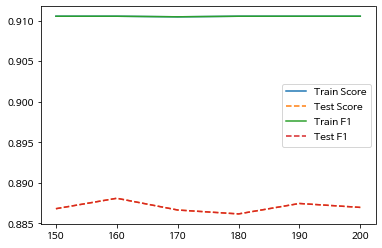

In [22]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# ntree
para_ntree = [10*ntree for ntree in range(15, 21)]


for v_ntree in para_ntree:
    rf = RFC(n_estimators = v_ntree)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_ntree, train_f1, linestyle='-', label="Train F1")
plt.plot(para_ntree, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [23]:
df_score_ntree.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
1,160,0.910532,0.888085,0.910532,0.888085
4,190,0.910532,0.887442,0.910532,0.887442
5,200,0.910532,0.886959,0.910532,0.886959
0,150,0.910532,0.886799,0.910532,0.886799
2,170,0.910463,0.886638,0.910463,0.886638
3,180,0.910532,0.886155,0.910532,0.886155


In [24]:
params['n_estimators'] = 160

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d

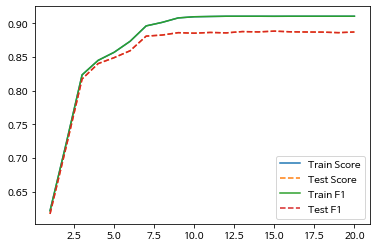

In [26]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(1, 21)]


for v_depth in para_depth:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = v_depth)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [28]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
14,15,0.910463,0.888406,0.910463,0.888406
12,13,0.910532,0.887763,0.910532,0.887763
15,16,0.910532,0.887442,0.910532,0.887442
13,14,0.910532,0.887281,0.910532,0.887281
19,20,0.910532,0.887120,0.910532,0.887120
16,17,0.910532,0.887120,0.910532,0.887120
17,18,0.910532,0.886959,0.910532,0.886959
10,11,0.910187,0.886477,0.910187,0.886477
8,9,0.908051,0.886155,0.908051,0.886155
18,19,0.910532,0.886155,0.910532,0.886155


In [29]:
params['max_depth'] = 15

### 최소 분리노드 크기 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

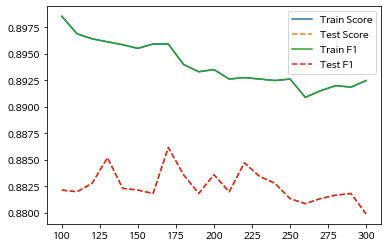

In [30]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*10 for split in range(10, 31)]


for v_split in para_split:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = v_split)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [31]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
7,170,0.895919,0.886155,0.895919,0.886155
3,130,0.896126,0.885191,0.896126,0.885191
12,220,0.892749,0.884708,0.892749,0.884708
10,200,0.893507,0.883583,0.893507,0.883583
8,180,0.893990,0.883583,0.893990,0.883583
13,230,0.892611,0.883422,0.892611,0.883422
2,120,0.896402,0.882779,0.896402,0.882779
14,240,0.892473,0.882779,0.892473,0.882779
4,140,0.895851,0.882296,0.895851,0.882296
0,100,0.898539,0.882135,0.898539,0.882135


In [32]:
params['min_samples_split'] = 170

### 최종노드 최소 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pi

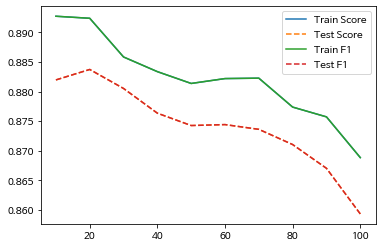

In [33]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf*10 for leaf in range(1, 11)]


for v_leaf in para_leaf:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = params['min_samples_split'],
             min_samples_leaf = v_leaf)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [34]:
df_score_leaf.sort_values('TestF1', ascending = False)

,leaf,TrainScore,TestScore,TrainF1,TestF1
1,20,0.892404,0.883743,0.892404,0.883743
0,10,0.892749,0.881975,0.892749,0.881975
2,30,0.885856,0.880527,0.885856,0.880527
3,40,0.883375,0.876347,0.883375,0.876347
5,60,0.882203,0.874417,0.882203,0.874417
4,50,0.881376,0.874256,0.881376,0.874256
6,70,0.882272,0.873613,0.882272,0.873613
7,80,0.877378,0.871040,0.877378,0.871040
8,90,0.875724,0.867020,0.875724,0.867020
9,100,0.868831,0.859302,0.868831,0.859302


In [35]:
params['min_samples_leaf'] = 20

### 최대 사용 변수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

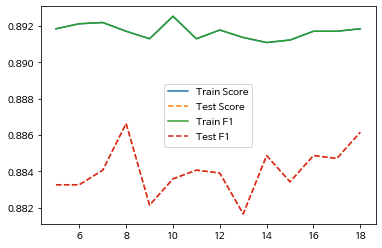

In [36]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(5, len(df_train_s.columns))]


for v_feature in para_feature:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [37]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
3,8,0.891715,0.886638,0.891715,0.886638
13,18,0.891853,0.886155,0.891853,0.886155
9,14,0.891095,0.884869,0.891095,0.884869
11,16,0.891715,0.884869,0.891715,0.884869
12,17,0.891715,0.884708,0.891715,0.884708
2,7,0.892197,0.884065,0.892197,0.884065
6,11,0.891301,0.884065,0.891301,0.884065
7,12,0.891784,0.883904,0.891784,0.883904
5,10,0.892542,0.883583,0.892542,0.883583
10,15,0.891232,0.883422,0.891232,0.883422


In [38]:
params['max_features'] = 8

### 최종 모형

In [39]:
rf_final = RFC(n_estimators = params['n_estimators'],
               max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = params['max_features'])
rf_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=170,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
y_pred = rf_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.883

Accuracy: 0.883

Confusion Mat:
[[3288  276]
 [ 450 2205]]


In [41]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
3,age_30대,0.148
13,cityGradeIS_1급지,0.143
14,cityGradeIS_2급지,0.132
2,age_20대,0.090
4,age_40대,0.078
15,cityGradeIS_3급지,0.060
16,cityGradeIS_4급지,0.056
9,residence_APART,0.054
11,residence_HOUSE,0.050
7,marital_MARRIED,0.040


Text(0, 0.5, '변수')

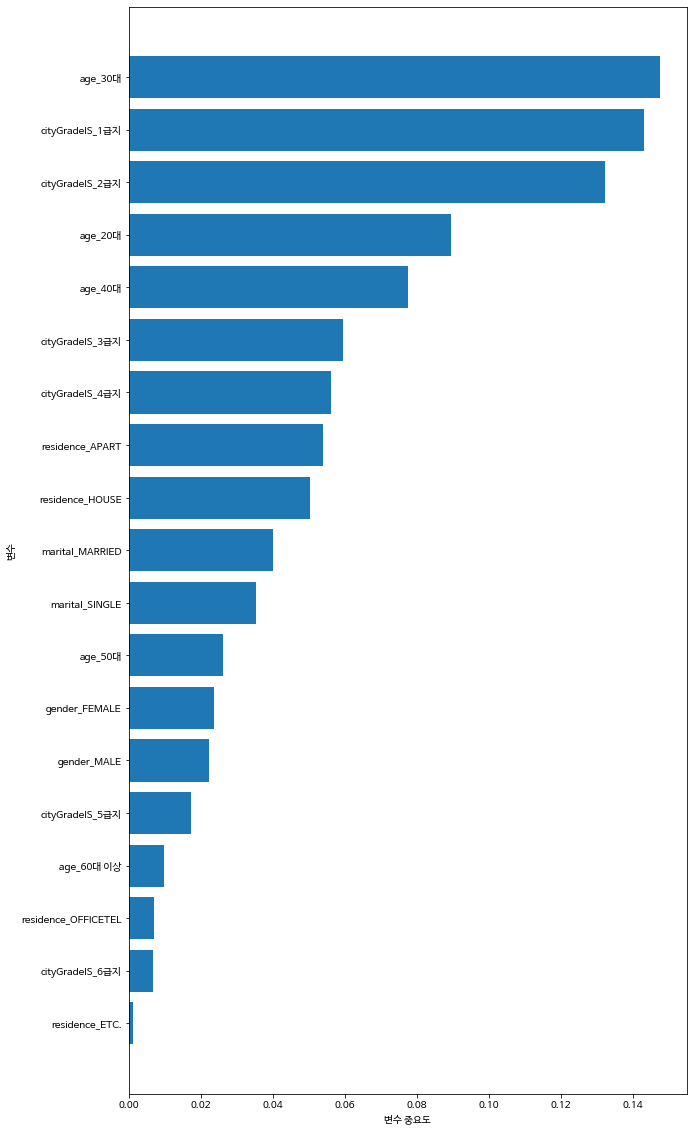

In [42]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 4종 모형

In [55]:
df_tree_short = df_tree.drop(['customerType', # 고객/법인 따로 분석
                              'channel', 'channelType',  # channelType 사용
                              'credit', 'payment', 'paymentCO', # 경향성 없음
                              'province', 'provinceIS',
                              'cityGrade', # 실거주지 정보 제외
                              'contractExtended', # 목표변수 파생변수 제외
                              'contractType', 'contractType_1', # 4개 범주 사용
                              'Termination_str', 
                              'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                             axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType_2']]

In [56]:
df_tree_y['contractType_2'].unique()

array(['I', 'M'], dtype=object)

In [57]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType_2', axis=1))
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20727 entries, 1 to 49644
Data columns (total 19 columns):
gender_FEMALE          20727 non-null uint8
gender_MALE            20727 non-null uint8
age_20대                20727 non-null uint8
age_30대                20727 non-null uint8
age_40대                20727 non-null uint8
age_50대                20727 non-null uint8
age_60대 이상             20727 non-null uint8
marital_MARRIED        20727 non-null uint8
marital_SINGLE         20727 non-null uint8
residence_APART        20727 non-null uint8
residence_ETC.         20727 non-null uint8
residence_HOUSE        20727 non-null uint8
residence_OFFICETEL    20727 non-null uint8
cityGradeIS_1급지        20727 non-null uint8
cityGradeIS_2급지        20727 non-null uint8
cityGradeIS_3급지        20727 non-null uint8
cityGradeIS_4급지        20727 non-null uint8
cityGradeIS_5급지        20727 non-null uint8
cityGradeIS_6급지        20727 non-null uint8
dtypes: uint8(19)
memory usage: 546.5 KB


In [58]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(14508, 19)
train data Y size:(14508, 1)
test data X size:(6219, 19)
test data Y size:(6219, 1)


# 랜덤포레스트

In [59]:
rf_default = RFC()
rf_default.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
y_train_pred = rf_default.predict(df_train_s)
y_test_pred = rf_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(rf_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(rf_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.731

F1 on Test: 0.714



### Parameter

In [62]:
params = {'max_depth': None,
          'n_estimators': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 숲의 나무 수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was e

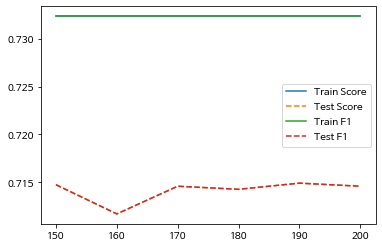

In [63]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# ntree
para_ntree = [10*ntree for ntree in range(15, 21)]


for v_ntree in para_ntree:
    rf = RFC(n_estimators = v_ntree)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_ntree, train_f1, linestyle='-', label="Train F1")
plt.plot(para_ntree, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [64]:
df_score_ntree.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
4,190,0.732355,0.714906,0.732355,0.714906
0,150,0.732355,0.714745,0.732355,0.714745
2,170,0.732355,0.714584,0.732355,0.714584
5,200,0.732355,0.714584,0.732355,0.714584
3,180,0.732355,0.714263,0.732355,0.714263
1,160,0.732355,0.711690,0.732355,0.711690


In [66]:
params['n_estimators'] = 150

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d

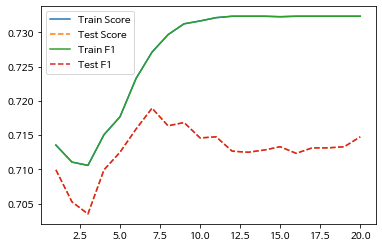

In [67]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(1, 21)]


for v_depth in para_depth:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = v_depth)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [68]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
6,7,0.727116,0.718926,0.727116,0.718926
8,9,0.731252,0.716836,0.731252,0.716836
7,8,0.729666,0.716353,0.729666,0.716353
5,6,0.723256,0.715871,0.723256,0.715871
10,11,0.732148,0.714745,0.732148,0.714745
19,20,0.732355,0.714745,0.732355,0.714745
9,10,0.731665,0.714584,0.731665,0.714584
14,15,0.732286,0.713298,0.732286,0.713298
18,19,0.732355,0.713298,0.732355,0.713298
16,17,0.732355,0.713137,0.732355,0.713137


In [69]:
params['max_depth'] = 7

### 최소 분리노드 크기 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

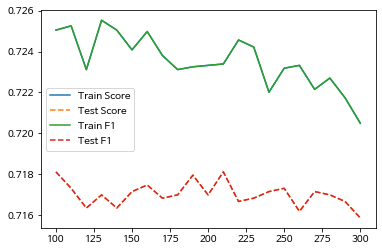

In [70]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*10 for split in range(10, 31)]


for v_split in para_split:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = v_split)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [71]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
0,100,0.725048,0.718122,0.725048,0.718122
11,210,0.723394,0.718122,0.723394,0.718122
9,190,0.723256,0.717961,0.723256,0.717961
6,160,0.724979,0.717479,0.724979,0.717479
1,110,0.725255,0.717318,0.725255,0.717318
15,250,0.723187,0.717318,0.723187,0.717318
17,270,0.722153,0.717157,0.722153,0.717157
5,150,0.724083,0.717157,0.724083,0.717157
14,240,0.722015,0.717157,0.722015,0.717157
18,280,0.722705,0.716996,0.722705,0.716996


In [72]:
params['min_samples_split'] = 210

### 최종노드 최소 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pi

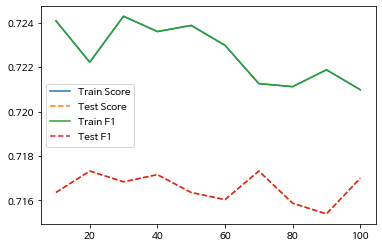

In [73]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf*10 for leaf in range(1, 11)]


for v_leaf in para_leaf:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = params['min_samples_split'],
             min_samples_leaf = v_leaf)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [74]:
df_score_leaf.sort_values('TestF1', ascending = False)

,leaf,TrainScore,TestScore,TrainF1,TestF1
1,20,0.722222,0.717318,0.722222,0.717318
6,70,0.721257,0.717318,0.721257,0.717318
3,40,0.723601,0.717157,0.723601,0.717157
9,100,0.720982,0.716996,0.720982,0.716996
2,30,0.724290,0.716836,0.724290,0.716836
0,10,0.724083,0.716353,0.724083,0.716353
4,50,0.723876,0.716353,0.723876,0.716353
5,60,0.722980,0.716032,0.722980,0.716032
7,80,0.721119,0.715871,0.721119,0.715871
8,90,0.721878,0.715388,0.721878,0.715388


In [75]:
params['min_samples_leaf'] = 20

### 최대 사용 변수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

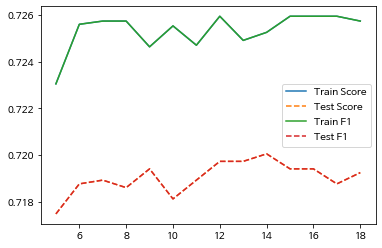

In [76]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(5, len(df_train_s.columns))]


for v_feature in para_feature:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [77]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
9,14,0.725255,0.720051,0.725255,0.720051
7,12,0.725944,0.719730,0.725944,0.719730
8,13,0.724910,0.719730,0.724910,0.719730
4,9,0.724635,0.719408,0.724635,0.719408
10,15,0.725944,0.719408,0.725944,0.719408
11,16,0.725944,0.719408,0.725944,0.719408
13,18,0.725738,0.719247,0.725738,0.719247
2,7,0.725738,0.718926,0.725738,0.718926
6,11,0.724704,0.718926,0.724704,0.718926
1,6,0.725600,0.718765,0.725600,0.718765


In [78]:
params['max_features'] = 14

### 최종 모형

In [79]:
rf_final = RFC(n_estimators = params['n_estimators'],
               max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = params['max_features'])
rf_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=210,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
y_pred = rf_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.720

Accuracy: 0.720

Confusion Mat:
[[2028  865]
 [ 878 2448]]


In [81]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
13,cityGradeIS_1급지,0.451
9,residence_APART,0.146
1,gender_MALE,0.105
0,gender_FEMALE,0.087
14,cityGradeIS_2급지,0.061
15,cityGradeIS_3급지,0.045
16,cityGradeIS_4급지,0.028
17,cityGradeIS_5급지,0.026
12,residence_OFFICETEL,0.013
18,cityGradeIS_6급지,0.012


Text(0, 0.5, '변수')

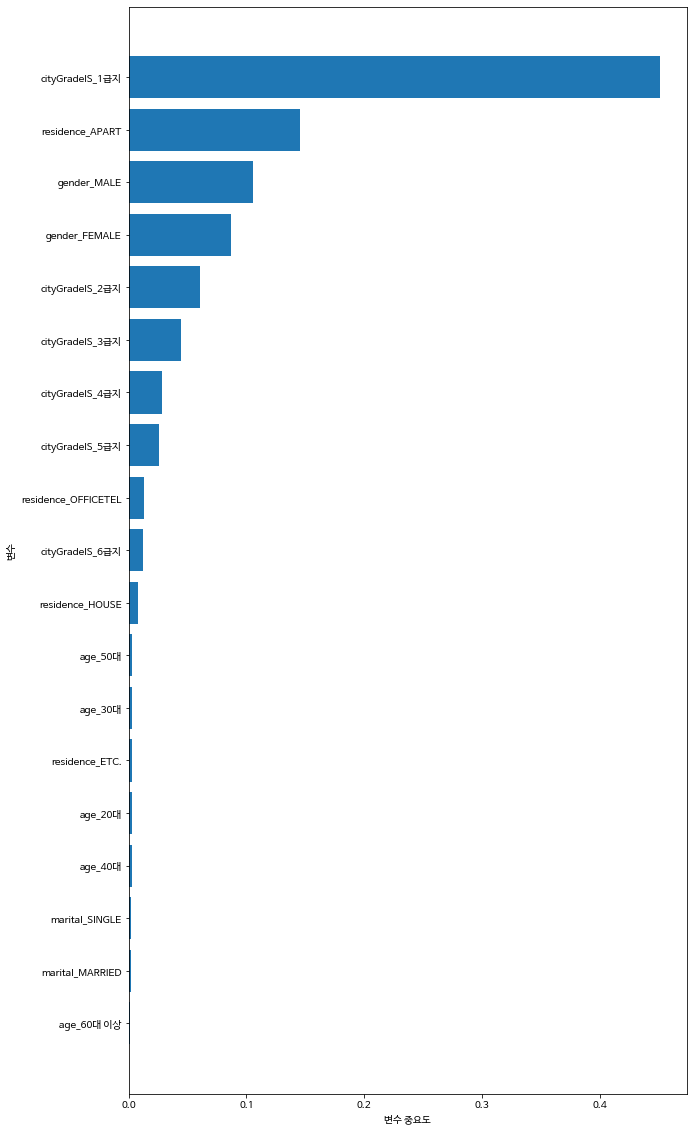

In [82]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 4종 동시 예측

In [94]:
df_tree_short = df_tree.drop(['customerType', # 고객/법인 따로 분석
                              'channel', 'channelType',  # channelType 사용
                              'credit', 'payment', 'paymentCO', # 경향성 없음
                              'province', 'provinceIS',
                              'cityGrade', # 실거주지 정보 제외
                              'contractExtended', # 목표변수 파생변수 제외
                              'contractType_1', 'contractType_2', # 4개 범주 사용
                              'Termination_str', 
                              'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                             axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType']]

In [95]:
df_tree_y['contractType'].unique()

array(['EIQ', 'HIQ', 'HMQ', 'EMQ'], dtype=object)

In [96]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType', axis=1))
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20727 entries, 1 to 49644
Data columns (total 19 columns):
gender_FEMALE          20727 non-null uint8
gender_MALE            20727 non-null uint8
age_20대                20727 non-null uint8
age_30대                20727 non-null uint8
age_40대                20727 non-null uint8
age_50대                20727 non-null uint8
age_60대 이상             20727 non-null uint8
marital_MARRIED        20727 non-null uint8
marital_SINGLE         20727 non-null uint8
residence_APART        20727 non-null uint8
residence_ETC.         20727 non-null uint8
residence_HOUSE        20727 non-null uint8
residence_OFFICETEL    20727 non-null uint8
cityGradeIS_1급지        20727 non-null uint8
cityGradeIS_2급지        20727 non-null uint8
cityGradeIS_3급지        20727 non-null uint8
cityGradeIS_4급지        20727 non-null uint8
cityGradeIS_5급지        20727 non-null uint8
cityGradeIS_6급지        20727 non-null uint8
dtypes: uint8(19)
memory usage: 546.5 KB


In [97]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(14508, 19)
train data Y size:(14508, 1)
test data X size:(6219, 19)
test data Y size:(6219, 1)


# 랜덤포레스트

In [98]:
rf_default = RFC()
rf_default.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
y_train_pred = rf_default.predict(df_train_s)
y_test_pred = rf_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(rf_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(rf_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.664

F1 on Test: 0.649



### Parameter

In [100]:
params = {'max_depth': None,
          'n_estimators': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 숲의 나무 수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was e

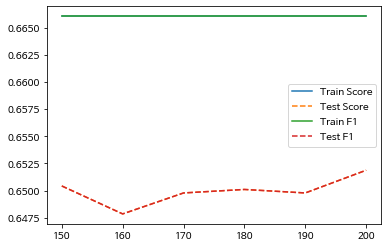

In [101]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# ntree
para_ntree = [10*ntree for ntree in range(15, 21)]


for v_ntree in para_ntree:
    rf = RFC(n_estimators = v_ntree)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_ntree, train_f1, linestyle='-', label="Train F1")
plt.plot(para_ntree, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [102]:
df_score_ntree.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
5,200,0.666046,0.651873,0.666046,0.651873
0,150,0.666046,0.650426,0.666046,0.650426
3,180,0.666046,0.650105,0.666046,0.650105
2,170,0.666046,0.649783,0.666046,0.649783
4,190,0.666046,0.649783,0.666046,0.649783
1,160,0.666046,0.647853,0.666046,0.647853


In [103]:
params['n_estimators'] = 200

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d

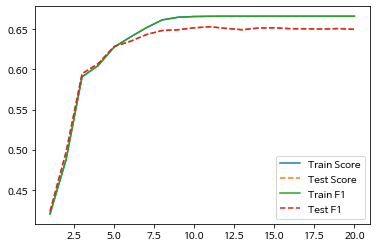

In [104]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(1, 21)]


for v_depth in para_depth:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = v_depth)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [105]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
10,11,0.665977,0.652999,0.665977,0.652999
9,10,0.665702,0.651712,0.665702,0.651712
14,15,0.666046,0.651712,0.666046,0.651712
13,14,0.666046,0.651391,0.666046,0.651391
11,12,0.666046,0.650909,0.666046,0.650909
18,19,0.666046,0.650748,0.666046,0.650748
15,16,0.666046,0.650587,0.666046,0.650587
16,17,0.666046,0.650426,0.666046,0.650426
17,18,0.666046,0.650105,0.666046,0.650105
19,20,0.666046,0.649783,0.666046,0.649783


In [106]:
params['max_depth'] = 11

### 최소 분리노드 크기 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

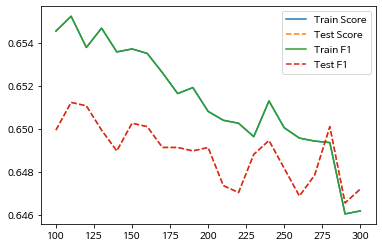

In [107]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*10 for split in range(10, 31)]


for v_split in para_split:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = v_split)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [108]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
1,110,0.655225,0.651230,0.655225,0.651230
2,120,0.653777,0.651069,0.653777,0.651069
5,150,0.653708,0.650265,0.653708,0.650265
18,280,0.649366,0.650105,0.649366,0.650105
6,160,0.653502,0.650105,0.653502,0.650105
0,100,0.654535,0.649944,0.654535,0.649944
3,130,0.654673,0.649944,0.654673,0.649944
14,240,0.651296,0.649461,0.651296,0.649461
10,200,0.650813,0.649140,0.650813,0.649140
8,180,0.651640,0.649140,0.651640,0.649140


In [109]:
params['min_samples_split'] = 110

### 최종노드 최소 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pi

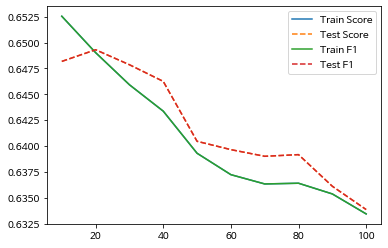

In [110]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf*10 for leaf in range(1, 11)]


for v_leaf in para_leaf:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_split = params['min_samples_split'],
             min_samples_leaf = v_leaf)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [111]:
df_score_leaf.sort_values('TestF1', ascending = False)

,leaf,TrainScore,TestScore,TrainF1,TestF1
1,20,0.649021,0.649301,0.649021,0.649301
0,10,0.652537,0.648175,0.652537,0.648175
2,30,0.645919,0.647853,0.645919,0.647853
3,40,0.643369,0.646245,0.643369,0.646245
4,50,0.639302,0.640457,0.639302,0.640457
5,60,0.637235,0.639653,0.637235,0.639653
7,80,0.636407,0.639170,0.636407,0.639170
6,70,0.636339,0.639009,0.636339,0.639009
8,90,0.635374,0.636115,0.635374,0.636115
9,100,0.633444,0.633864,0.633444,0.633864


In [112]:
params['min_samples_leaf'] = 20

### 최대 사용 변수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

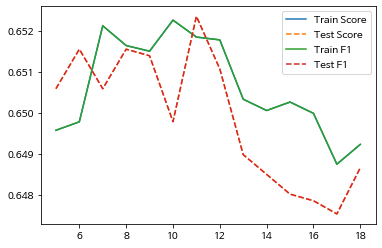

In [113]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(5, len(df_train_s.columns))]


for v_feature in para_feature:
    rf = RFC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    rf.fit(df_train_s, df_train_y)
    y_train_pred = rf.predict(df_train_s)
    y_test_pred = rf.predict(df_test_s)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [114]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
6,11,0.651847,0.652356,0.651847,0.652356
1,6,0.649779,0.651552,0.649779,0.651552
3,8,0.651640,0.651552,0.651640,0.651552
4,9,0.651503,0.651391,0.651503,0.651391
7,12,0.651778,0.651069,0.651778,0.651069
0,5,0.649573,0.650587,0.649573,0.650587
2,7,0.652123,0.650587,0.652123,0.650587
5,10,0.652261,0.649783,0.652261,0.649783
8,13,0.650331,0.648979,0.650331,0.648979
13,18,0.649228,0.648657,0.649228,0.648657


In [115]:
params['max_features'] = 11

### 최종 모형

In [116]:
rf_final = RFC(n_estimators = params['n_estimators'],
               max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = params['max_features'])
rf_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features=11, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=110,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [117]:
y_pred = rf_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.651

Accuracy: 0.651

Confusion Mat:
[[ 986  452  118   50]
 [ 420 1360   71  122]
 [ 181   31  820  258]
 [  62   88  320  880]]


In [118]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
3,age_30대,0.195
4,age_40대,0.125
13,cityGradeIS_1급지,0.122
14,cityGradeIS_2급지,0.084
2,age_20대,0.075
9,residence_APART,0.066
15,cityGradeIS_3급지,0.048
1,gender_MALE,0.044
0,gender_FEMALE,0.042
8,marital_SINGLE,0.041


Text(0, 0.5, '변수')

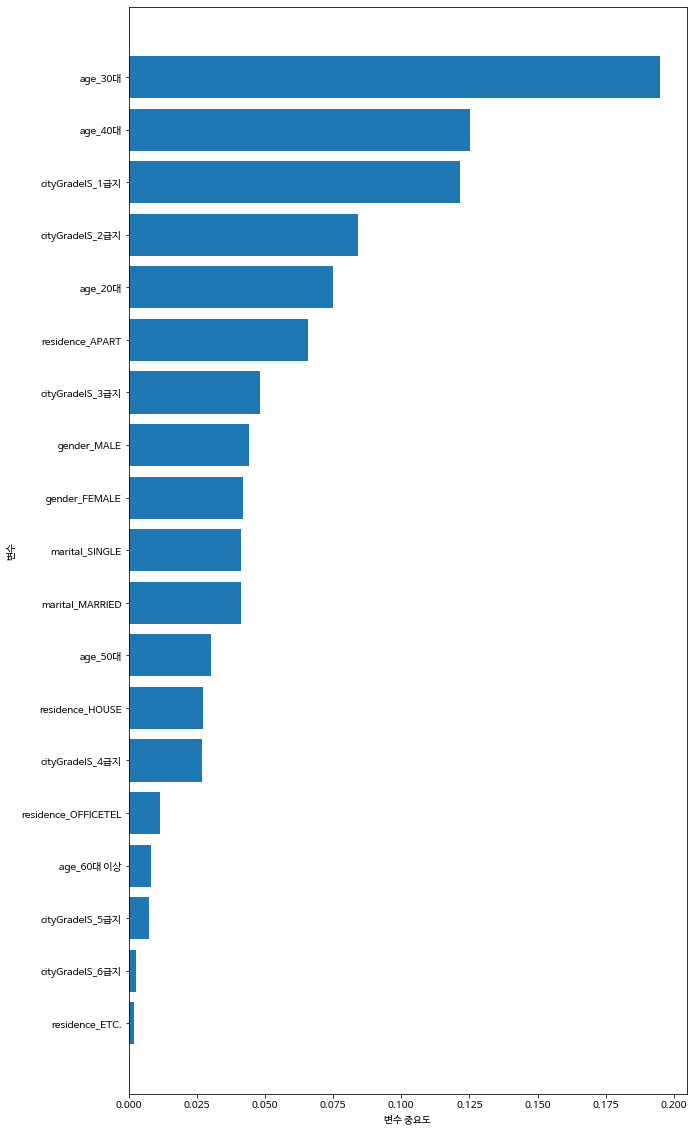

In [119]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 전체 데이터에 예측

In [120]:
v_feature_name

Index(['gender_FEMALE', 'gender_MALE', 'age_20대', 'age_30대', 'age_40대',
       'age_50대', 'age_60대 이상', 'marital_MARRIED', 'marital_SINGLE',
       'residence_APART', 'residence_ETC.', 'residence_HOUSE',
       'residence_OFFICETEL', 'cityGradeIS_1급지', 'cityGradeIS_2급지',
       'cityGradeIS_3급지', 'cityGradeIS_4급지', 'cityGradeIS_5급지',
       'cityGradeIS_6급지'],
      dtype='object')

In [127]:
df_customer = df.query('customerType == "PERSONAL" and contractType_1 != "M"')

df_total_x = pd.get_dummies(df_customer[['gender', 'age', 'marital', 'residence', 'cityGradeIS']])
df_total_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21362 entries, 1 to 49644
Data columns (total 19 columns):
gender_FEMALE          21362 non-null uint8
gender_MALE            21362 non-null uint8
age_20대                21362 non-null uint8
age_30대                21362 non-null uint8
age_40대                21362 non-null uint8
age_50대                21362 non-null uint8
age_60대 이상             21362 non-null uint8
marital_MARRIED        21362 non-null uint8
marital_SINGLE         21362 non-null uint8
residence_APART        21362 non-null uint8
residence_ETC.         21362 non-null uint8
residence_HOUSE        21362 non-null uint8
residence_OFFICETEL    21362 non-null uint8
cityGradeIS_1급지        21362 non-null uint8
cityGradeIS_2급지        21362 non-null uint8
cityGradeIS_3급지        21362 non-null uint8
cityGradeIS_4급지        21362 non-null uint8
cityGradeIS_5급지        21362 non-null uint8
cityGradeIS_6급지        21362 non-null uint8
dtypes: uint8(19)
memory usage: 563.3 KB


In [128]:
y_pred = rf_final.predict(df_total_x)
y_pred = pd.DataFrame(y_pred, index = df_total_x.index, columns = ['predType_4종'])

In [129]:
df_total_pred = df_customer
df_total_pred = df_total_pred.merge(y_pred, how = 'inner', left_index = True, right_index = True)

In [130]:
df_total_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21362 entries, 1 to 49644
Data columns (total 24 columns):
gender              21362 non-null object
customerType        21362 non-null object
age                 21362 non-null object
marital             21362 non-null object
residence           21362 non-null object
channel             21362 non-null object
credit              21362 non-null object
payment             21362 non-null object
paymentCO           21362 non-null object
province            21362 non-null object
provinceIS          21362 non-null object
cityGrade           21362 non-null object
channelType         21362 non-null object
contractExtended    21362 non-null object
contractType        21362 non-null object
contractType_1      21362 non-null object
contractType_2      21362 non-null object
cityGradeIS         21362 non-null object
Termination_str     21362 non-null object
maxDay_str          21362 non-null object
maxGift_str         21362 non-null object
Terminati

## 예측치 결합

In [133]:
conditions = [(df_total_pred['contractType'] == df_total_pred['predType_4종'])]
choices = [1]
df_total_pred['match_4종'] = np.select(conditions, choices, default=0)
df_total_pred.head()

,gender,customerType,age,marital,residence,channel,credit,payment,paymentCO,province,...,contractType_1,contractType_2,cityGradeIS,Termination_str,maxDay_str,maxGift_str,Termination_rate,overDue_str,predType_4종,match_4종
1,FEMALE,PERSONAL,20대,MARRIED,OFFICETEL,렌탈재계약,MIDDLE,CMS,국민은행,서울시,...,E,I,1급지,중도 해약 X,토요일,지급 O,A,0일,EIQ,1
2,FEMALE,PERSONAL,30대,MARRIED,OFFICETEL,렌탈총판,HIGH,CMS,기업은행,충청도,...,H,I,1급지,중도 해약 X,화요일,지급 O,B,0일,HIQ,1
5,FEMALE,PERSONAL,40대,MARRIED,APART,서비스 방문,LOW,CMS,국민은행,서울시,...,H,M,2급지,중도 해약 X,일요일,지급 X,A,0일,HMQ,1
11,FEMALE,PERSONAL,50대,MARRIED,HOUSE,서비스 방문,MIDDLE,CMS,새마을금고,부산시,...,E,I,1급지,중도 해약 X,일요일,지급 X,A,0일,EIQ,1
16,FEMALE,PERSONAL,30대,MARRIED,HOUSE,하이마트,MIDDLE,CARD,외환카드,경기도,...,H,M,3급지,중도 해약 X,화요일,지급 O,B,0일,HMQ,1


In [141]:
# 예측 정확도 
df_total_pred.match_4종.describe()

count    21362.000000
mean         0.637721
std          0.480670
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: match_4종, dtype: float64

In [135]:
df_total_pred[['contractType', 'predType_4종', 'match_4종']].head(30)

,contractType,predType_4종,match_4종
1,EIQ,EIQ,1
2,HIQ,HIQ,1
5,HMQ,HMQ,1
11,EIQ,EIQ,1
16,HMQ,HMQ,1
18,EIQ,EIQ,1
19,EIQ,EIQ,1
22,EIQ,EIQ,1
23,HMQ,HMQ,1
24,HIQ,HIQ,1


## Match 여부에 따른 중도이탈률

In [136]:
df_crosstab = pd.concat([pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_4종, margins=True),
                         pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_4종).apply(lambda r: r/r.sum(), axis=0),                   
                         pd.crosstab(df_total_pred.Termination_str, df_total_pred.match_4종).apply(lambda r: r/r.sum(), axis=1)])
df_crosstab.round(3)

match_4종,0,1,All
Termination_str,,,
중도 해약 O,495.000,140.000,635.0
중도 해약 X,7244.000,13483.000,20727.0
All,7739.000,13623.000,21362.0
중도 해약 O,0.064,0.010,NaN
중도 해약 X,0.936,0.990,NaN
중도 해약 O,0.780,0.220,NaN
중도 해약 X,0.349,0.651,NaN
